# Customer Churn Prediction via Random Forest Classifier

## Module Imports

In [3]:
#%pip install shap
#%pip install mlxtend

Defaulting to user installation because normal site-packages is not writeable
Looking in links: /usr/share/pip-wheels
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Looking in links: /usr/share/pip-wheels
Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import shap
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import MinMaxScaler, QuantileTransformer, RobustScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import make_scorer

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


## Data Preprocessing

In [3]:
df_churn_original = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")

In [5]:
df_churn_original.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


### Class Counts

In [19]:
df_churn_original["Churn"].value_counts()

No     5174
Yes    1869
Name: Churn, dtype: int64

In [29]:
print("Percent of \"No\" to Total: " + str(round(5174./len(df_churn_original["Churn"]) * 100., 2)) + "%")
print("Percent of \"Yes\" to Total: " + str(round(1869./len(df_churn_original["Churn"]) * 100., 2)) + "%")

Percent of "No" to Total: 73.46%
Percent of "Yes" to Total: 26.54%


* ***The ratio of "No" to "Yes", i.e. not churned vs. churned, is great for business, but somewhat imbalanced for our classification model. This will be important later.***

In [36]:
df_churn_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


* ***NoteL*** `TotalCharges` has a `dtype` of `object`, but because this column has numeric values, it *should* be `float64`. Let's investigate.

In [39]:
df_churn_original.nunique()

customerID          7043
gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
tenure                73
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1585
TotalCharges        6531
Churn                  2
dtype: int64

* Our first round of checking for nulls didn't turn up anything suspicious.
* However, when I used `pd.to_numeric()` on the `TotalCharges` column the first time, an error popped up that it couldn't be completed.
* Therefore, ***there might be whitespace for values instead***, so let's check that.

In [42]:
print('Number of blank TotalCharges entries: ', df_churn_original['TotalCharges'].str.count('\s+').sum())
print('Percent of blank entries compared to total: ', df_churn_original['TotalCharges'].str.count('\s+').sum() / len(df_churn_original['TotalCharges']) * 100.0)

Number of blank TotalCharges entries:  11
Percent of blank entries compared to total:  0.1561834445548772


* It turns out that there are 11 blank entries in the `TotalCharges` column!
* Since these 11 entries account for $\frac{11}{7043} \approx 0.156\% $ of rows, it should be safe to drop these rows via a new df, `df_churn_cleaned`.

In [45]:
df_churn_cleaned = df_churn_original.copy()

In [47]:
df_churn_cleaned = df_churn_cleaned[df_churn_cleaned['TotalCharges'].str.match('\s+') == False].reset_index(drop=True)

In [49]:
df_churn_cleaned['TotalCharges'] = pd.to_numeric(df_churn_cleaned['TotalCharges'])

In [51]:
df_churn_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7032 non-null   object 
 1   gender            7032 non-null   object 
 2   SeniorCitizen     7032 non-null   int64  
 3   Partner           7032 non-null   object 
 4   Dependents        7032 non-null   object 
 5   tenure            7032 non-null   int64  
 6   PhoneService      7032 non-null   object 
 7   MultipleLines     7032 non-null   object 
 8   InternetService   7032 non-null   object 
 9   OnlineSecurity    7032 non-null   object 
 10  OnlineBackup      7032 non-null   object 
 11  DeviceProtection  7032 non-null   object 
 12  TechSupport       7032 non-null   object 
 13  StreamingTV       7032 non-null   object 
 14  StreamingMovies   7032 non-null   object 
 15  Contract          7032 non-null   object 
 16  PaperlessBilling  7032 non-null   object 


Now that the `dtype` for `TotalCharges` was successfully converted to `float64`, let's start encoding!

## Encoding Features and Classification Target

### Categorical Features

In [56]:
categorical_features = df_churn_cleaned.select_dtypes(include="object").columns.values.tolist()
categorical_features.remove("customerID")
categorical_features.remove("Churn")
categorical_features.append("SeniorCitizen")

### Numerical Features

In [59]:
numerical_features = df_churn_cleaned.select_dtypes(include=["int64", "float64"]).columns.values.tolist()
numerical_features.remove("SeniorCitizen")

### Classification Target

In [62]:
target = ["Churn"]

### Encoding

* `categorical_features` will be encoded with `OneHotEncoder()`, as scikit-learn's current implementations of decision tree-based classes *do not work with categorical data*.
* `numerical_features` *will not be encoded* because decision trees aren't affected by different scales between features.
* `target` will be encoded with `LabelEncoder()` as is standard.

In [70]:
one_hot = OneHotEncoder()
le = LabelEncoder()

preprocessor = ColumnTransformer(
   [
       ("numerical", "passthrough", numerical_features),
       ("categorical", one_hot, categorical_features)]
)

X = preprocessor.fit_transform(df_churn_cleaned[numerical_features + categorical_features])
y = le.fit_transform(np.ravel(df_churn_cleaned[target]))

In [96]:
le.transform(["Yes", "No"])

array([1, 0])

## Creating and Analyzing Decision Tree Classifier

In [75]:
random_state = 42

In [77]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = random_state, stratify = y)

In [79]:
pd.DataFrame(X_train)

,0,1,2,3,4,5,6,7,8,9,...,36,37,38,39,40,41,42,43,44,45
0,65.0,94.55,6078.75,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,26.0,35.75,1022.50,0.0,1.0,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,68.0,90.20,6297.65,1.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,3.0,84.30,235.05,0.0,1.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4,49.0,40.65,2070.75,1.0,0.0,0.0,1.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5620,65.0,70.95,4555.20,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
5621,15.0,75.30,1147.45,1.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
5622,36.0,92.90,3379.25,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
5623,10.0,65.90,660.05,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0


### Creating Decision Tree Classifier

In [82]:
decision_tree = DecisionTreeClassifier(criterion="gini", max_depth=4, class_weight = "balanced")

### Running the Classifier

In [85]:
decision_tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=4)

### Cross-Validation Score

In [88]:
decision_tree_cross_val_scores = cross_val_score(decision_tree, X_train, y_train, cv = 10)
print('Cross-validation score mean: ', np.mean(decision_tree_cross_val_scores))
print('Cross-validation score standard deviation: ', np.std(decision_tree_cross_val_scores))

Cross-validation score mean:  0.7331564508890477
Cross-validation score standard deviation:  0.03076923421731379


Without any hyperparameter tuning and using a plain decision tree, we get a cross-validation score $\mu \approx 0.733, \sigma \approx 0.031$, which isn't amazing.

### Precision, Recall, and F1-Scores

In [92]:
y_pred_decision_tree = decision_tree.predict(X_test)

In [94]:
print(classification_report(y_pred_decision_tree, y_test))

              precision    recall  f1-score   support

           0       0.67      0.91      0.77       764
           1       0.81      0.47      0.59       643

    accuracy                           0.71      1407
   macro avg       0.74      0.69      0.68      1407
weighted avg       0.73      0.71      0.69      1407



#### Some Takeaways

* Based on the confusion matrix above, the decision tree has great precision in classifying customers who have churned, and even better in recalling unchurned customers. (81% and 91%, respectively.)
* However, because this dataset's classes are imbalanced, there's a better way to measure performance: ***the Matthews correlation coefficient (MCC)***.

### Matthews Correlation Coefficient (MCC)

* $ \huge MCC = \frac{TP \times TN - FP \times FN}{\sqrt{(TP + FP)(TP + FN)(TN + FP)(TN + FN)}}$
* For binary classification, best value is $+1$, worst is $-1$.
* Although no one metric can entirely describe the performance of a classification algorithm, the MCC is a great option for imbalanced classes.
    * i.e. Even if there are a large number of misclassifications of the positive class, if the positive class is bigger enough than the negative class, the number of correct predictions of the positive class will far outweigh the incorrect predictions of the negative class just from the size difference alone.
* Therefore, ***let's look at the MCC!***

In [196]:
print("MCC: ", matthews_corrcoef(y_test, y_pred_decision_tree))

MCC:  0.42334861978196986


* Now let's look at this model's PR AUC curve.

### Visualizing the PR AUC Curve

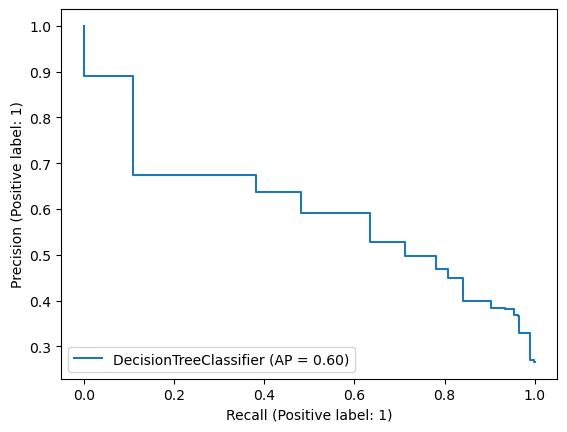

In [192]:
PrecisionRecallDisplay.from_estimator(decision_tree, X_test, y_test)

#### Feature Importances

In [71]:
df_decision_tree_feature_importances = pd.DataFrame({"feature_names" : preprocessor.get_feature_names_out(), 
                                                     "feature_importances" : decision_tree.feature_importances_})

In [72]:
# Visualizing only importances with nonzero values, sorting them in descending order.

df_decision_tree_feature_importances = df_decision_tree_feature_importances[df_decision_tree_feature_importances["feature_importances"] > 0].sort_values(by="feature_importances", ascending = False)

In [73]:
# Deleting 'categorical__' and 'numerical__' from feature names for readability.

df_decision_tree_feature_importances["feature_names"] = df_decision_tree_feature_importances["feature_names"].str.replace("categorical__","").str.replace("numerical__", "").str.replace("_", ": ")

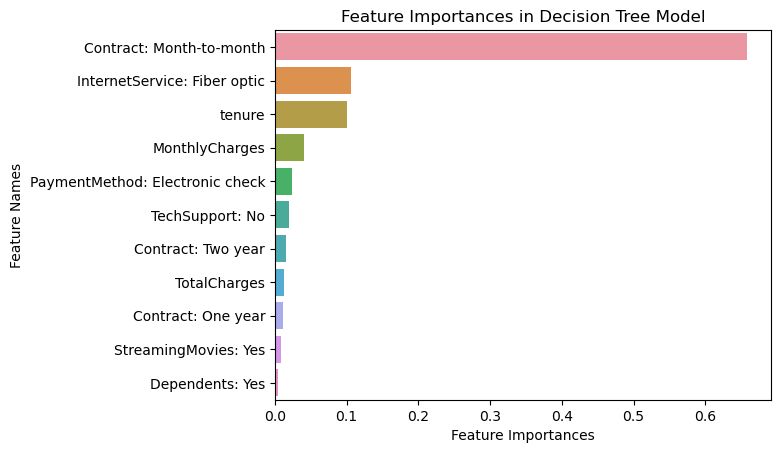

In [74]:
ax = sns.barplot(data=df_decision_tree_feature_importances, x="feature_importances", y="feature_names")
#feature_importances = df_decision_tree_feature_importances["feature_importances"].values
#for i, v in enumerate(feature_importances):
#    ax.text(i, 0, str(v), ha="left")
plt.ylabel("Feature Names")
plt.xlabel("Feature Importances")
plt.title("Feature Importances in Decision Tree Model")
plt.show()

### Initial Takeaways

* It makes sense that a month-to-month contract is a huge deciding factor for churn - *if it's just a monthly contract, then customers can stop paying much more easily than with a longer contract.*

<Axes: xlabel='Contract', ylabel='count'>

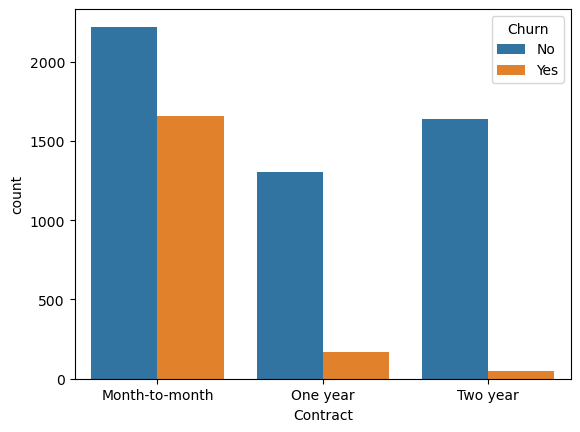

In [192]:
sns.countplot(data = df_churn_cleaned, x = "Contract", hue = "Churn")

* Tenure's importance also makes sense - *the longer a customer stays with the company, the more likely they'll stay around.*

<Axes: xlabel='tenure', ylabel='Count'>

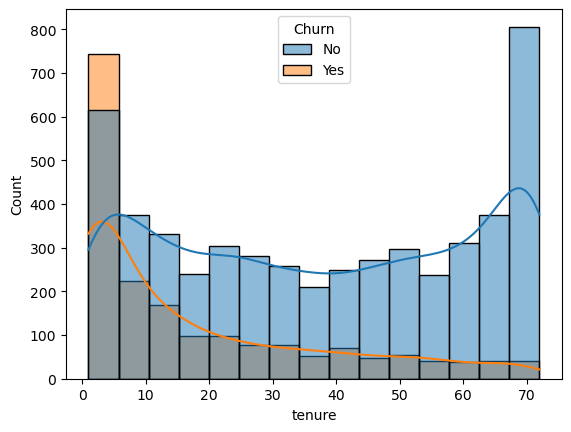

In [196]:
sns.histplot(data = df_churn_cleaned, x = "tenure", hue = "Churn", kde = True)

* Fiber optic internet service is somewhat surprising. However, at the time of data collection for this particular dataset, a fiber optic connection was expensive, so it might be a reasonable hypothesis that *customers with fiber optic connections are more committed to consistent internet service, and thus will have a higher tenure.*

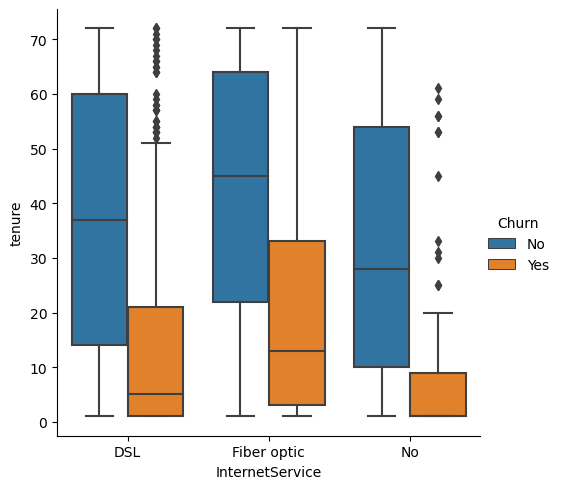

In [190]:
sns.catplot(data = df_churn_cleaned, x = "InternetService", y = "tenure", kind = "box", hue = "Churn")

### SHAP Values

In [76]:
decision_tree_explainer = shap.TreeExplainer(decision_tree)
decision_tree_shap_values =decision_tree_explainer.shap_values(X_test)

In [78]:
model_feature_names = [f.replace('categorical__', '').replace('numerical__', '').replace('_', ': ') for f in preprocessor.get_feature_names_out().tolist()]

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


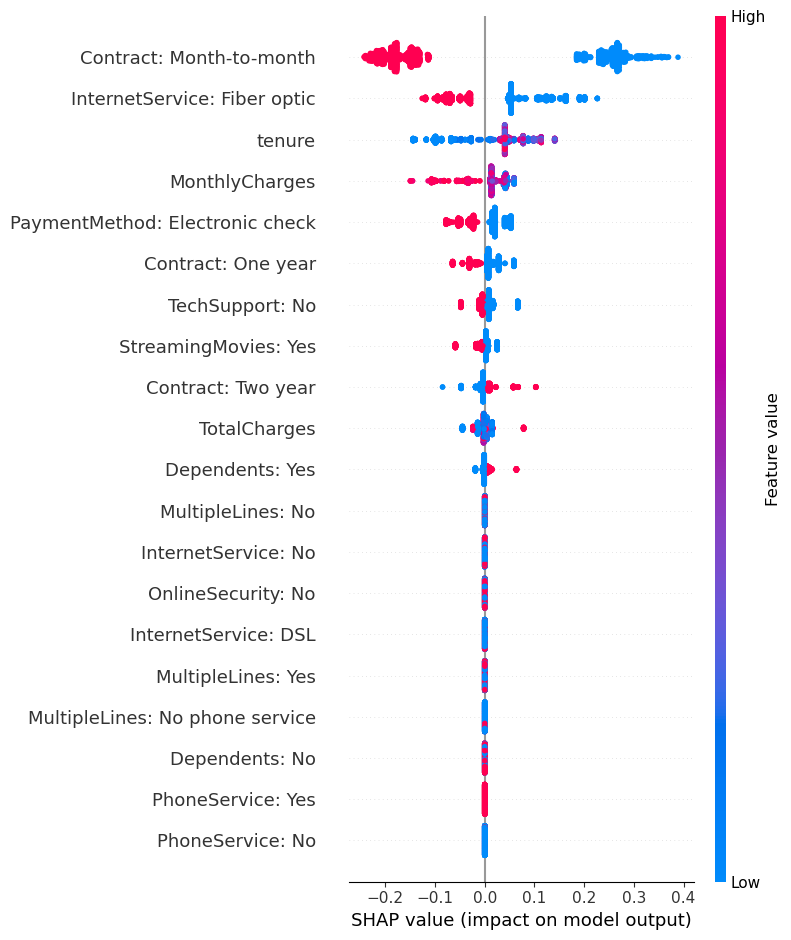

In [79]:
shap.summary_plot(decision_tree_shap_values[0], X_test, feature_names = model_feature_names, class_names=['No','Yes'])

## Creating and Analyzing Random Forest Classifier

Instead of seeing the forest for the (singular decision) trees, we'll use a random forest classification model and *attempt to increase model performance.*

In [102]:
random_forest = RandomForestClassifier()

In [109]:
random_forest.fit(X_train, y_train)

RandomForestClassifier()

In [111]:
random_forest_cross_val_scores = cross_val_score(random_forest, X_train, y_train, cv = 10)
print('Cross-validation score mean: ', np.mean(random_forest_cross_val_scores))
print('Cross-validation score standard deviation: ', np.std(random_forest_cross_val_scores))

Cross-validation score mean:  0.7836340018836558
Cross-validation score standard deviation:  0.017655292772562427


Without any hyperparameter tuning and using a plain random forest, we get a cross-validation score of $\mu \approx 0.784, \sigma \approx 0.018$, which is better than the first decision tree's $\mu \approx 0.733, \sigma \approx 0.031$, but we can definitely do better! However, we also need to look at the MCC.

### Matthews Correlation Coefficient

In [114]:
y_pred_random_forest = random_forest.predict(X_test)

In [194]:
print("MCC: ", matthews_corrcoef(y_test, y_pred_random_forest))

MCC:  0.42757309397875654


This is barely better than the decision tree, so let's look at the PR AUC curve.

### PR AUC Curve

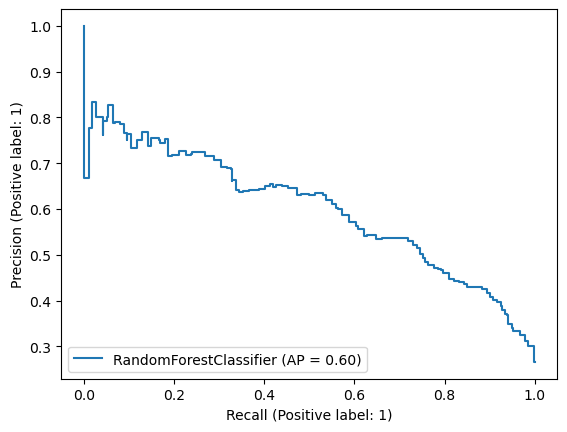

In [200]:
PrecisionRecallDisplay.from_estimator(random_forest, X_test, y_test)

In [120]:
df_random_forest_feature_importances = pd.DataFrame({"feature_names" : preprocessor.get_feature_names_out(), 
                                                     "feature_importances" : random_forest.feature_importances_})

### Feature Importances

In [123]:
df_random_forest_feature_importances = df_random_forest_feature_importances[df_random_forest_feature_importances["feature_importances"] > 0].sort_values(by="feature_importances", ascending = False).iloc[:10, :]

In [125]:
df_random_forest_feature_importances["feature_names"] = df_random_forest_feature_importances["feature_names"].str.replace("categorical__","").str.replace("numerical__", "").str.replace("_", ": ")

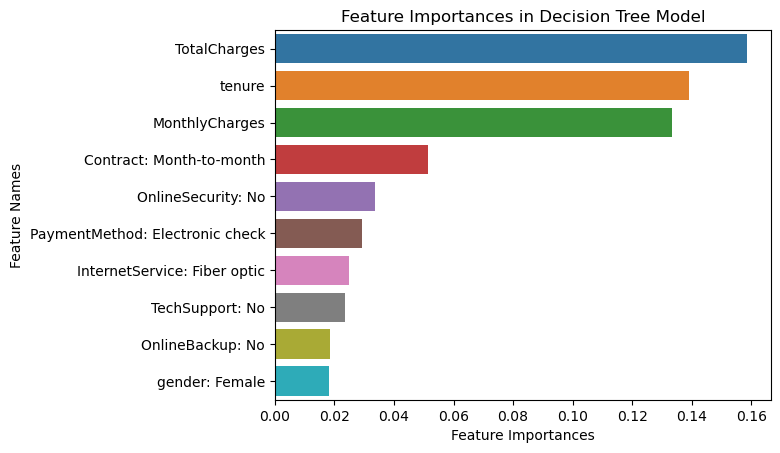

In [127]:
ax = sns.barplot(data=df_random_forest_feature_importances, x="feature_importances", y="feature_names")
#feature_importances = df_random_forest_feature_importances["feature_importances"].values
#for i, v in enumerate(feature_importances):
#    ax.text(i, 0, str(v), ha="left")
plt.ylabel("Feature Names")
plt.xlabel("Feature Importances")
plt.title("Feature Importances in Decision Tree Model")
plt.show()

### Random Forest SHAP Values

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


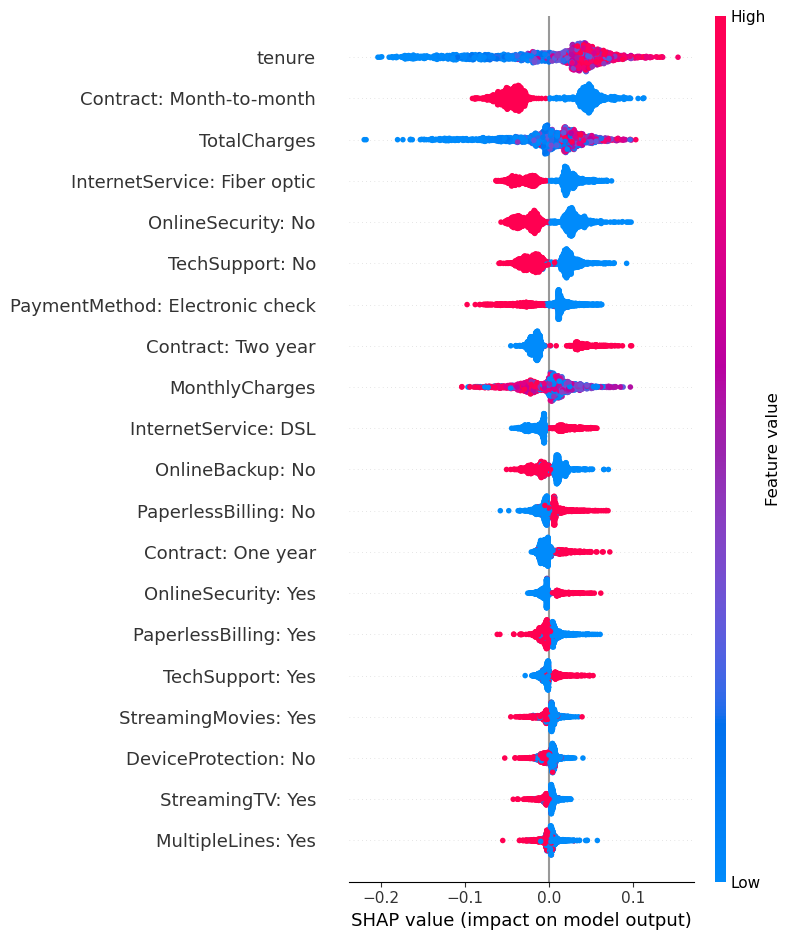

In [220]:
random_forest_explainer = shap.TreeExplainer(random_forest)
random_forest_shap_values = random_forest_explainer.shap_values(X_test)
shap.summary_plot(random_forest_shap_values[0], X_test, feature_names = model_feature_names, class_names=['No','Yes'])

## Weight of Evidence Encoding

* **Weight of evidence** can be thought of as log-odds: $WoE = ln(\frac{p(Y=1}{p(Y=0})$.
* In this model, weight-of-evidence (WoE) encoding is effective for a few reasons:
    * Unlike one-hot encoding, **WoE encoding of categorical features does NOT produce a sparse matrix, especially important in this dataset which has a substantial fraction of categorical features.**
    * Because there is no sparse matrix, **the number of features is kept smaller, making training easier and more efficient, and there's less of an impact from the curse of dimensionality.**

In [129]:
def WoE_Encoder(df, X, y):
    keys = df[X].unique().tolist()
    targets = df[y].unique().tolist()
    values = []
    
    for key in keys:
        value = np.log((len(df[(df[X] == key) & (df[y] == targets[1])]) / len(df[df[y] == targets[1]])) / (len(df[(df[X] == key) & (df[y] == targets[0])]) / len(df[df[y] == targets[0]])))
        values.append(value)
    
    encoder_map = dict(zip(keys, values))
    
    return df[X].map(encoder_map)

### WoE-encoded `DataFrame`

In [132]:
df_churn_woe = pd.DataFrame()
for categorical_feature in categorical_features:
    df_churn_woe[categorical_feature] = WoE_Encoder(df_churn_cleaned, categorical_feature, "Churn")
for numerical_feature in numerical_features:
    df_churn_woe[numerical_feature] = df_churn_cleaned[numerical_feature]
df_churn_woe["Churn"] = df_churn_cleaned["Churn"]

In [134]:
df_churn_woe

,gender,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn
0,0.019437,-0.387958,0.229013,-0.082498,-0.082498,-0.434003,0.684248,-0.274966,0.574694,0.678852,0.332031,0.340714,0.722408,0.334461,0.826969,-0.155837,1,29.85,29.85,No
1,-0.019249,0.306848,0.229013,0.008642,-0.078170,-0.434003,-0.746990,0.608219,-0.218397,0.678852,0.332031,0.340714,-1.046622,-0.614421,-0.420824,-0.155837,34,56.95,1889.50,No
2,-0.019249,0.306848,0.229013,0.008642,-0.078170,-0.434003,-0.746990,-0.274966,0.574694,0.678852,0.332031,0.340714,0.722408,0.334461,-0.420824,-0.155837,2,53.85,108.15,Yes
3,-0.019249,0.306848,0.229013,-0.082498,-0.082498,-0.434003,-0.746990,0.608219,-0.218397,-0.703190,0.332031,0.340714,-1.046622,-0.614421,-0.588662,-0.155837,45,42.30,1840.75,No
4,0.019437,0.306848,0.229013,0.008642,-0.078170,0.688937,0.684248,0.608219,0.574694,0.678852,0.332031,0.340714,0.722408,0.334461,0.826969,-0.155837,2,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7027,-0.019249,-0.387958,-0.677417,0.008642,0.103595,-0.434003,-0.746990,0.608219,-0.218397,-0.703190,0.174272,0.166549,-1.046622,0.334461,-0.420824,-0.155837,24,84.80,1990.50,No
7028,0.019437,-0.387958,-0.677417,0.008642,0.103595,0.688937,0.684248,-0.274966,-0.218397,0.678852,0.174272,0.166549,-1.046622,0.334461,-0.698770,-0.155837,72,103.20,7362.90,No
7029,0.019437,-0.387958,-0.677417,-0.082498,-0.082498,-0.434003,-0.746990,0.608219,0.574694,0.678852,0.332031,0.340714,0.722408,0.334461,0.826969,-0.155837,11,29.60,346.45,No
7030,-0.019249,-0.387958,0.229013,0.008642,0.103595,0.688937,0.684248,0.608219,0.574694,0.678852,0.332031,0.340714,0.722408,0.334461,-0.420824,0.680242,4,74.40,306.60,Yes


In [136]:
X_woe = df_churn_woe.iloc[:, :-1]

In [138]:
X_woe

,gender,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
0,0.019437,-0.387958,0.229013,-0.082498,-0.082498,-0.434003,0.684248,-0.274966,0.574694,0.678852,0.332031,0.340714,0.722408,0.334461,0.826969,-0.155837,1,29.85,29.85
1,-0.019249,0.306848,0.229013,0.008642,-0.078170,-0.434003,-0.746990,0.608219,-0.218397,0.678852,0.332031,0.340714,-1.046622,-0.614421,-0.420824,-0.155837,34,56.95,1889.50
2,-0.019249,0.306848,0.229013,0.008642,-0.078170,-0.434003,-0.746990,-0.274966,0.574694,0.678852,0.332031,0.340714,0.722408,0.334461,-0.420824,-0.155837,2,53.85,108.15
3,-0.019249,0.306848,0.229013,-0.082498,-0.082498,-0.434003,-0.746990,0.608219,-0.218397,-0.703190,0.332031,0.340714,-1.046622,-0.614421,-0.588662,-0.155837,45,42.30,1840.75
4,0.019437,0.306848,0.229013,0.008642,-0.078170,0.688937,0.684248,0.608219,0.574694,0.678852,0.332031,0.340714,0.722408,0.334461,0.826969,-0.155837,2,70.70,151.65
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7027,-0.019249,-0.387958,-0.677417,0.008642,0.103595,-0.434003,-0.746990,0.608219,-0.218397,-0.703190,0.174272,0.166549,-1.046622,0.334461,-0.420824,-0.155837,24,84.80,1990.50
7028,0.019437,-0.387958,-0.677417,0.008642,0.103595,0.688937,0.684248,-0.274966,-0.218397,0.678852,0.174272,0.166549,-1.046622,0.334461,-0.698770,-0.155837,72,103.20,7362.90
7029,0.019437,-0.387958,-0.677417,-0.082498,-0.082498,-0.434003,-0.746990,0.608219,0.574694,0.678852,0.332031,0.340714,0.722408,0.334461,0.826969,-0.155837,11,29.60,346.45
7030,-0.019249,-0.387958,0.229013,0.008642,0.103595,0.688937,0.684248,0.608219,0.574694,0.678852,0.332031,0.340714,0.722408,0.334461,-0.420824,0.680242,4,74.40,306.60


### Training on WoE-encoded `df`

In [141]:
X_woe_train, X_woe_test, y_woe_train, y_woe_test = train_test_split(X_woe, y, test_size=0.2, stratify=y)

#### Decision Tree

In [144]:
decision_tree_woe = DecisionTreeClassifier(criterion="gini", max_depth=4)

In [146]:
decision_tree_woe.fit(X_woe_train, y_woe_train)

DecisionTreeClassifier(max_depth=4)

In [148]:
decision_tree_woe_cross_val_scores = cross_val_score(decision_tree_woe, X_woe_train, y_woe_train, cv = 10)
print('Cross-validation score mean: ', np.mean(decision_tree_woe_cross_val_scores))
print('Cross-validation score standard deviation: ', np.std(decision_tree_woe_cross_val_scores))

Cross-validation score mean:  0.7914644475768474
Cross-validation score standard deviation:  0.016728999917872533


### Matthews Correlation Coefficient

In [151]:
y_pred_decision_tree_woe = decision_tree_woe.predict(X_woe_test)

In [153]:
matthews_corrcoef(y_pred_decision_tree_woe, y_woe_test)

0.42871587865797245

### PR AUC Curve

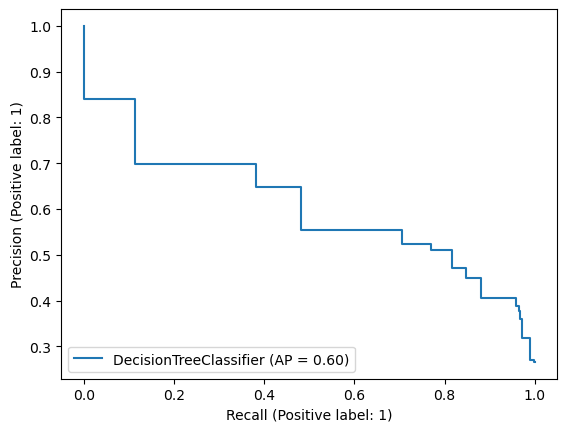

In [204]:
PrecisionRecallDisplay.from_estimator(decision_tree_woe, X_woe_test, y_woe_test)

* Before hyperparameter tuning, just using WoE-encoding alone on categorical features, we get $\mu \approx 0.788, \sigma \approx 0.019$, which is close to the first random forest's cross-validated accuracy stats of $\mu \approx 0.791, \sigma \approx 0.017$, so there's progress!
* The MCC of 0.429 is still not that great, though.
* However, ***let's start using `GridSearchCV` to start tuning!***

#### Decision Tree `GridSearchCV`

In [157]:
mcc_scorer = make_scorer(matthews_corrcoef)

In [159]:
param_grid = {'max_depth' : [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}

In [161]:
grid_search_decision_tree_woe = GridSearchCV(estimator=decision_tree_woe,
                      param_grid=param_grid,
                      scoring=mcc_scorer,
                      cv=10,
                      refit=True,
                      n_jobs=-1)
grid_search_decision_tree_woe.fit(X_woe_train, y_woe_train)
print('Best score: ', grid_search_decision_tree_woe.best_score_)
print('Best params: ', grid_search_decision_tree_woe.best_params_)

Best score:  0.4564493546080663
Best params:  {'max_depth': 5}


In [169]:
decision_tree_woe_tuned = DecisionTreeClassifier(criterion="gini", max_depth=5)
decision_tree_woe_tuned.fit(X_woe_train, y_woe_train)
y_pred_decision_tree_woe_tuned = decision_tree_woe_tuned.predict(X_woe_test)

decision_tree_woe_tuned_cross_val_scores = cross_val_score(decision_tree_woe_tuned, X_woe_train, y_woe_train, cv = 10)

print('Cross-validation score mean: ', np.mean(decision_tree_woe_tuned_cross_val_scores))
print('Cross-validation score standard deviation: ', np.std(decision_tree_woe_tuned_cross_val_scores))
print('MCC: ', matthews_corrcoef(y_pred_decision_tree_woe_tuned, y_woe_test))

Cross-validation score mean:  0.7905744518119127
Cross-validation score standard deviation:  0.017867703457872156
MCC:  0.4940663157804163


* With `max_depth = 5`, we now get cross-validated accuracy stats of $\mu \approx 0.791, \sigma \approx 0.008$, which is pretty much the same performance as the first random forest!
* Moreover, the MCC has gone up to 0.494, higher than the score of 0.429 from the first random forest.
* Now let's do another `GridSearchCV`, this time on a random forest and a much more comprehensive hyperparameter search.

### PR AUC Curve

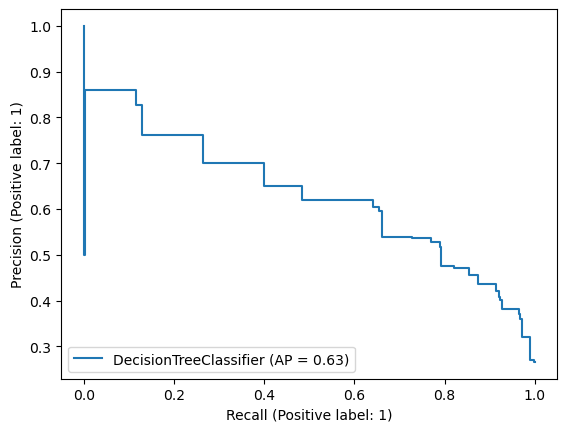

In [222]:
PrecisionRecallDisplay.from_estimator(decision_tree_woe_tuned, X_woe_test, y_woe_test)

### Random Tree `GridSearchCV`

In [172]:
random_forest_woe = RandomForestClassifier(n_estimators = 100,
                                           max_depth = 4,
                                           random_state = random_state,
                                           class_weight = None)
random_forest_woe.fit(X_woe_train, y_woe_train)

random_forest_woe_cross_val_scores = cross_val_score(random_forest_woe, X_woe_train, y_woe_train, cv = 10)
print('Cross-validation score mean: ', np.mean(random_forest_woe_cross_val_scores))
print('Cross-validation score standard deviation: ', np.std(random_forest_woe_cross_val_scores))

random_forest_param_grid = {'max_depth' : [5, 6, 7, 8],
                            'n_estimators' : [100, 250, 500, 750, 1000]}

grid_search_random_forest_woe = GridSearchCV(estimator=random_forest_woe,
                      param_grid=random_forest_param_grid,
                      scoring=mcc_scorer,
                      cv=10,
                      refit=True,
                      n_jobs=-1)
grid_search_random_forest_woe.fit(X_woe_train, y_woe_train)
print('Best score: ', grid_search_random_forest_woe.best_score_)
print('Best params: ', grid_search_random_forest_woe.best_params_)

Cross-validation score mean:  0.7932447551563497
Cross-validation score standard deviation:  0.014611697527428151
Best score:  0.4496962903521444
Best params:  {'max_depth': 8, 'n_estimators': 500}


In [210]:
random_forest_woe_tuned = RandomForestClassifier(n_estimators = 500,
                                           max_depth = 8,
                                           random_state = random_state,
                                           class_weight = None)
random_forest_woe_tuned.fit(X_woe_train, y_woe_train)

random_forest_woe_tuned_cross_val_scores = cross_val_score(random_forest_woe_tuned, X_woe_train, y_woe_train, cv = 10)

y_pred_random_forest_woe_tuned = random_forest_woe_tuned.predict(X_woe_test)

print('Cross-validation score mean: ', np.mean(random_forest_woe_tuned_cross_val_scores))
print('Cross-validation score standard deviation: ', np.std(random_forest_woe_tuned_cross_val_scores))
print('MCC: ', matthews_corrcoef(y_pred_random_forest_woe_tuned, y_woe_test))

Cross-validation score mean:  0.7992879401781255
Cross-validation score standard deviation:  0.012546136894718847
MCC:  0.4990979343559511


* With $\mu \approx 0.808, \sigma \approx 0.016$, this is our best performance yet!
* Also, the MCC is 0.499, which is also our best yet!

### PR AUC Curve

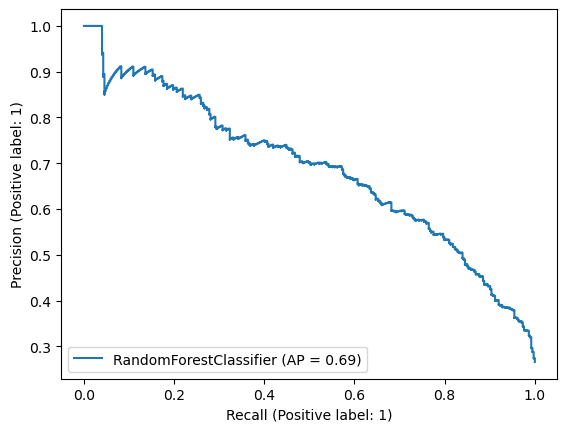

In [225]:
PrecisionRecallDisplay.from_estimator(random_forest_woe_tuned, X_woe_test, y_woe_test)